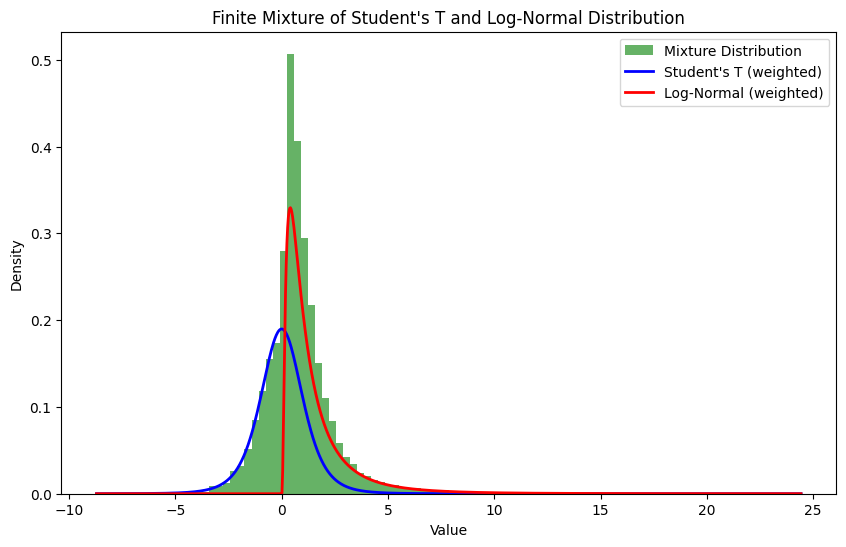

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t, lognorm

# Parameters for the Student's T distribution
df = 5  # degrees of freedom

# Parameters for the Log-Normal distribution
s = 0.954  # shape parameter (standard deviation of the underlying normal distribution)
scale = np.exp(0)  # scale parameter, equivalent to exp(mean) of the underlying normal distribution

# Number of samples
size = 10000

# Mixing proportions
weights = [0.5, 0.5]  # equal weights for both distributions

# Generate samples
# Choose the distribution for each sample based on the weights
choices = np.random.choice([0, 1], size=size, p=weights)

# Generate the samples from the chosen distributions
samples = np.zeros(size)
samples[choices == 0] = t.rvs(df, size=np.sum(choices == 0))  # Student's T
samples[choices == 1] = lognorm.rvs(s, scale=scale, size=np.sum(choices == 1))  # Log-Normal

# Plot the histogram of the mixture distribution
plt.figure(figsize=(10, 6))
plt.hist(samples, bins=100, density=True, alpha=0.6, color='g', label='Mixture Distribution')

# Plot the individual distributions for reference
x = np.linspace(min(samples), max(samples), 1000)
plt.plot(x, t.pdf(x, df) * weights[0], 'b-', lw=2, label='Student\'s T (weighted)')
plt.plot(x, lognorm.pdf(x, s, scale=scale) * weights[1], 'r-', lw=2, label='Log-Normal (weighted)')

plt.title('Finite Mixture of Student\'s T and Log-Normal Distribution')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend(loc='best')
plt.show()


In [22]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split

from uni2ts.eval_util.plot import plot_single, plot_next_multi
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule

from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS, NBEATSx, TSMixerx

from neuralforecast.losses.numpy import mae, mse

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('data/medium_views_published_holidays.csv')
df['ds'] = pd.to_datetime(df['ds'])

df.head()

,unique_id,ds,y,published,is_holiday
0,0,2020-01-01,1131,0.0,1
1,0,2020-01-02,1764,0.0,0
2,0,2020-01-03,1699,0.0,0
3,0,2020-01-04,1322,0.0,0
4,0,2020-01-05,1491,0.0,0


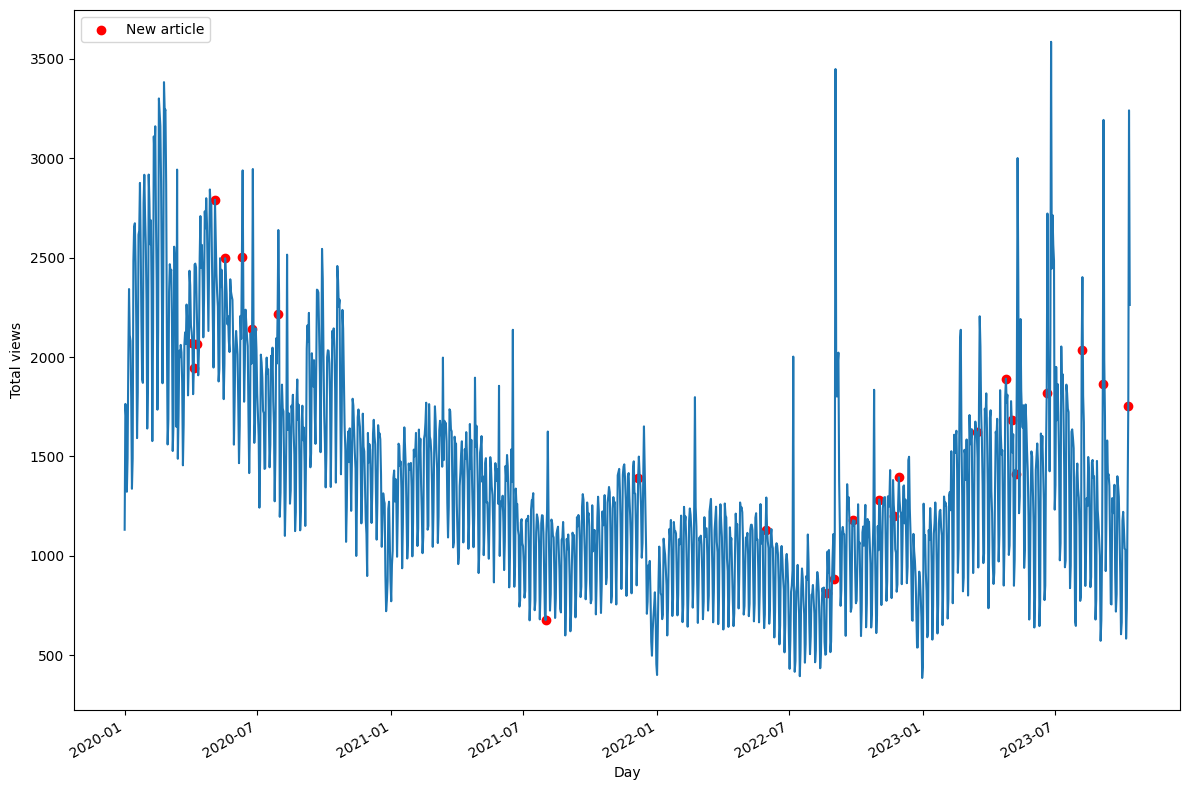

In [4]:
published_dates = df[df['published'] == 1]

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(df['ds'], df['y'])
ax.scatter(published_dates['ds'], published_dates['y'], marker='o', color='red', label='New article')
ax.set_xlabel('Day')
ax.set_ylabel('Total views')
ax.legend(loc='best')

fig.autofmt_xdate()
plt.tight_layout()

## Forecasting with Moirai

In [5]:
moirai_df = df.set_index('ds')
moirai_df.head()

,unique_id,y,published,is_holiday
ds,,,,
2020-01-01,0,1131,0.0,1
2020-01-02,0,1764,0.0,0
2020-01-03,0,1699,0.0,0
2020-01-04,0,1322,0.0,0
2020-01-05,0,1491,0.0,0


In [6]:
ds = PandasDataset.from_long_dataframe(
    moirai_df,
    target='y',
    item_id='unique_id',
    feat_dynamic_real=["published", "is_holiday"]
)

In [7]:
test_size = 168
horizon = 7

train, test_template = split(
    ds, offset=-test_size
)

test_data = test_template.generate_instances(
    prediction_length=horizon,
    windows=test_size//horizon,
    distance=horizon
)

In [8]:
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-small"),
    prediction_length=horizon,
    context_length=500,
    patch_size="auto",
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
)

predictor = model.create_predictor(batch_size=32)
forecasts = predictor.predict(test_data.input)
forecasts = list(forecasts)

In [9]:
def get_median_and_ci(data, 
                      horizon,
                      id,
                      confidence=0.80):

    n_samples, n_timesteps = data.shape
    
    # Calculate the median for each timestep
    medians = np.median(data, axis=0)
    
    # Calculate the lower and upper percentile for the given confidence interval
    lower_percentile = (1 - confidence) / 2 * 100
    upper_percentile = (1 + confidence) / 2 * 100
    
    # Calculate the lower and upper bounds for each timestep
    lower_bounds = np.percentile(data, lower_percentile, axis=0)
    upper_bounds = np.percentile(data, upper_percentile, axis=0)

    # Create a DataFrame with the results
    df = pd.DataFrame({
        'unique_id': id,
        'Moirai': medians,
        f'Moirai-lo-{int(confidence*100)}': lower_bounds,
        f'Moirai-hi-{int(confidence*100)}': upper_bounds
    })
    
    return df

In [12]:
moirai_preds = [
    get_median_and_ci(
        data=forecasts[i].samples,
        horizon=horizon,
        id=1
    )
    for i in range(24)
]

moirai_preds_df = pd.concat(moirai_preds, axis=0, ignore_index=True)

moirai_preds_df.head()

,unique_id,Moirai,Moirai-lo-80,Moirai-hi-80
0,1,1327.187500,943.035852,1560.381055
1,1,1408.401611,974.349878,1641.376099
2,1,1404.814331,1000.267719,1649.537817
3,1,1506.153564,974.538055,1793.713953
4,1,1575.557617,1053.415601,1879.903711


In [13]:
len(moirai_preds_df)

168

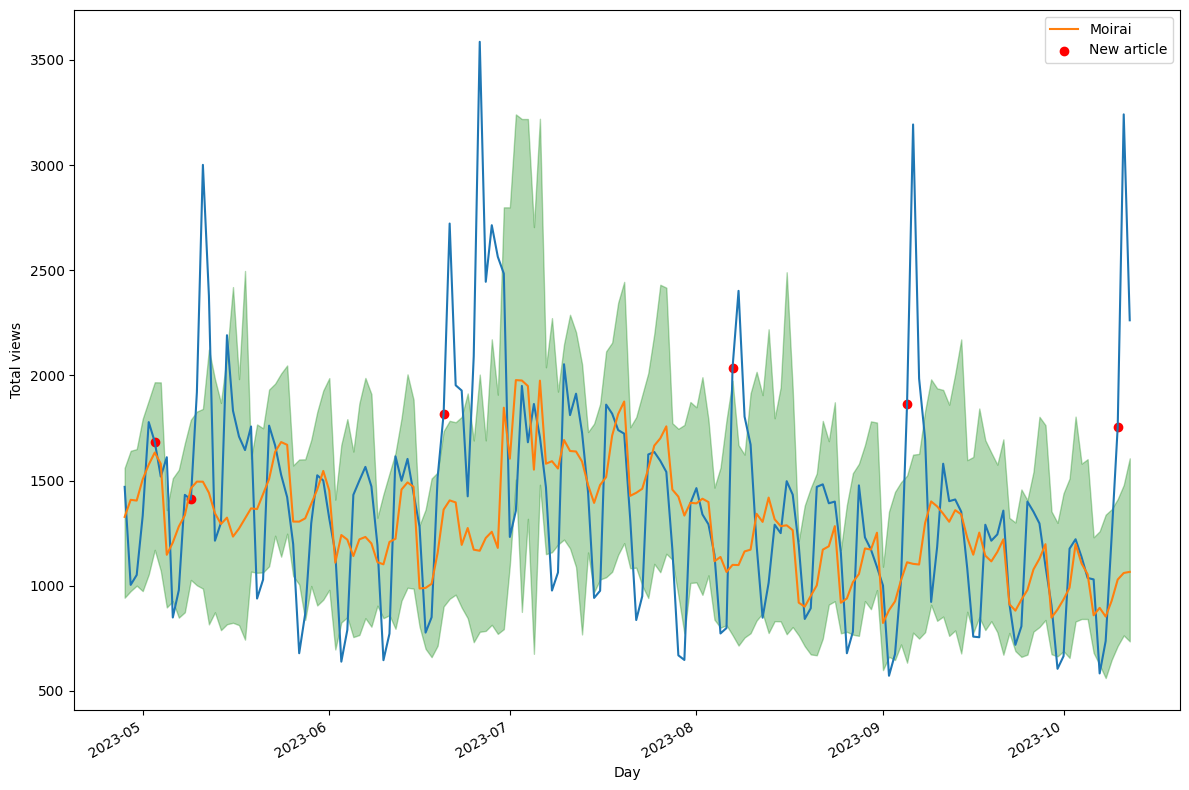

In [15]:
test = df[-168:]

published_dates = test[test['published'] == 1]

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(test['ds'], test['y'])
ax.plot(test['ds'], moirai_preds_df['Moirai'], label='Moirai')
ax.fill_between(test['ds'], moirai_preds_df['Moirai-lo-80'], moirai_preds_df['Moirai-hi-80'], color="green", alpha=0.3)

ax.scatter(published_dates['ds'], published_dates['y'], marker='o', color='red', label='New article')

ax.set_xlabel('Day')
ax.set_ylabel('Total views')
ax.legend(loc='best')

fig.autofmt_xdate()

plt.tight_layout()

## Data-specific models

In [25]:
models = [NHITS(h=horizon,
                input_size=5*horizon,
                futr_exog_list=["published", "is_holiday"],
                max_steps=1000,
                early_stop_patience_steps=3,),
         NBEATSx(h=horizon,
                input_size=5*horizon,
                futr_exog_list=["published", "is_holiday"], 
                max_steps=1000,
                early_stop_patience_steps=3,),
         TSMixerx(h=horizon,
                  input_size=5*horizon,
                  n_series=1,
                  futr_exog_list=["published", "is_holiday"],
                  max_steps=1000,
                  early_stop_patience_steps=3)]

Seed set to 1
Seed set to 1
Seed set to 1


In [26]:
nf = NeuralForecast(models=models, freq='D')

preds_df = nf.cross_validation(
    df=df,
    step_size=horizon,
    val_size=168,
    test_size=168,
    n_windows=None
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 2.5 M 
-----------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.189    Total estimated model params size (MB)


Epoch 99: 100%|████████████████| 1/1 [00:00<00:00,  9.17it/s, v_num=115, train_loss_step=119.0, train_loss_epoch=126.0]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.64it/s]
Epoch 199: 100%|█| 1/1 [00:00<00:00,  9.01it/s, v_num=115, train_loss_step=105.0, train_loss_epoch=106.0, valid_loss=13
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.63it/s]
Epoch 299: 100%|█| 1/1 [00:00<00:00,  9.17it/s, v_num=115, train_loss_step=90.30, train_loss_epoch=93.20, valid_loss=13
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 99.98it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 2.6 M 
-----------------------------------------------
2.6 M     Trainable params
630       Non-trainable params
2.6 M     Total params
10.343    Total estimated model params size (MB)


Epoch 99: 100%|████████████████| 1/1 [00:00<00:00,  9.71it/s, v_num=117, train_loss_step=107.0, train_loss_epoch=102.0]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.55it/s]
Epoch 199: 100%|█| 1/1 [00:00<00:00,  9.52it/s, v_num=117, train_loss_step=81.70, train_loss_epoch=85.20, valid_loss=12
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.63it/s]
Epoch 299: 100%|█| 1/1 [00:00<00:00,  9.17it/s, v_num=117, train_loss_step=58.40, train_loss_epoch=60.90, valid_loss=13
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 111.11it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type                     | Params
-----------------------------------------------------------------
0 | loss                | MAE                      | 0     
1 | padder              | ConstantPad1d            | 0     
2 | scaler              | TemporalNorm             | 0     
3 | norm                | ReversibleInstanceNorm1d | 2     
4 | temporal_projection | Linear                   | 252   
5 | feature_mixer_hist  | FeatureMixing            | 5.6 K 
6 | feature_mixer_futr  | FeatureMixing            | 5.4 K 
7 | first_mixing        | MixingLayer              | 23.4 K
8 | mixing_block        | Sequential               | 20.3 K
9 | out                 | Linear                   | 65    
-----------------------------------------------------------------
55.1 K    Trainable params
0         Non-trainable params
55

Epoch 99: 100%|████████████████| 1/1 [00:00<00:00, 32.26it/s, v_num=119, train_loss_step=173.0, train_loss_epoch=176.0]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.55it/s]
Epoch 199: 100%|█| 1/1 [00:00<00:00, 32.26it/s, v_num=119, train_loss_step=171.0, train_loss_epoch=149.0, valid_loss=18
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.55it/s]
Epoch 299: 100%|█| 1/1 [00:00<00:00, 31.25it/s, v_num=119, train_loss_step=154.0, train_loss_epoch=133.0, valid_loss=16
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|█| 1/1 [00:00<00:00, 13.33it/s, v_num=119, train_loss_step=128.0, train_loss_epoch=128.0, valid_loss=13


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.02it/s]


In [27]:
preds_df.head()

,ds,cutoff,NHITS,NBEATSx,TSMixerx,y
unique_id,,,,,,
0,2023-04-28,2023-04-27,1469.853760,1397.124023,1336.226685,1470
0,2023-04-29,2023-04-27,988.000488,889.344360,945.159424,1004
0,2023-04-30,2023-04-27,1241.285645,1081.555176,1080.111938,1051
0,2023-05-01,2023-04-27,1990.450928,1833.803833,1660.152588,1333
0,2023-05-02,2023-04-27,1962.685791,1855.616089,1692.313110,1778


In [28]:
len(preds_df)

168

## Evaluation

In [32]:
all_preds = preds_df[['NHITS', 'NBEATSx', 'TSMixerx', 'y']]
all_preds['Moirai'] = moirai_preds_df['Moirai'].values

all_preds = all_preds.reset_index(drop=False)

all_preds.head()

,unique_id,NHITS,NBEATSx,TSMixerx,y,Moirai
0,0,1469.853760,1397.124023,1336.226685,1470,1327.187500
1,0,988.000488,889.344360,945.159424,1004,1408.401611
2,0,1241.285645,1081.555176,1080.111938,1051,1404.814331
3,0,1990.450928,1833.803833,1660.152588,1333,1506.153564
4,0,1962.685791,1855.616089,1692.313110,1778,1575.557617


In [34]:
from utilsforecast.losses import mae, smape
from utilsforecast.evaluation import evaluate

evaluation = evaluate(
    all_preds,
    metrics=[mae, smape],
    target_col='y',
    id_col='unique_id'
)

evaluation

,unique_id,metric,NHITS,NBEATSx,TSMixerx,Moirai
0,0,mae,318.543743,286.994123,246.220201,355.094691
1,0,smape,0.103200,0.095035,0.080169,0.126297


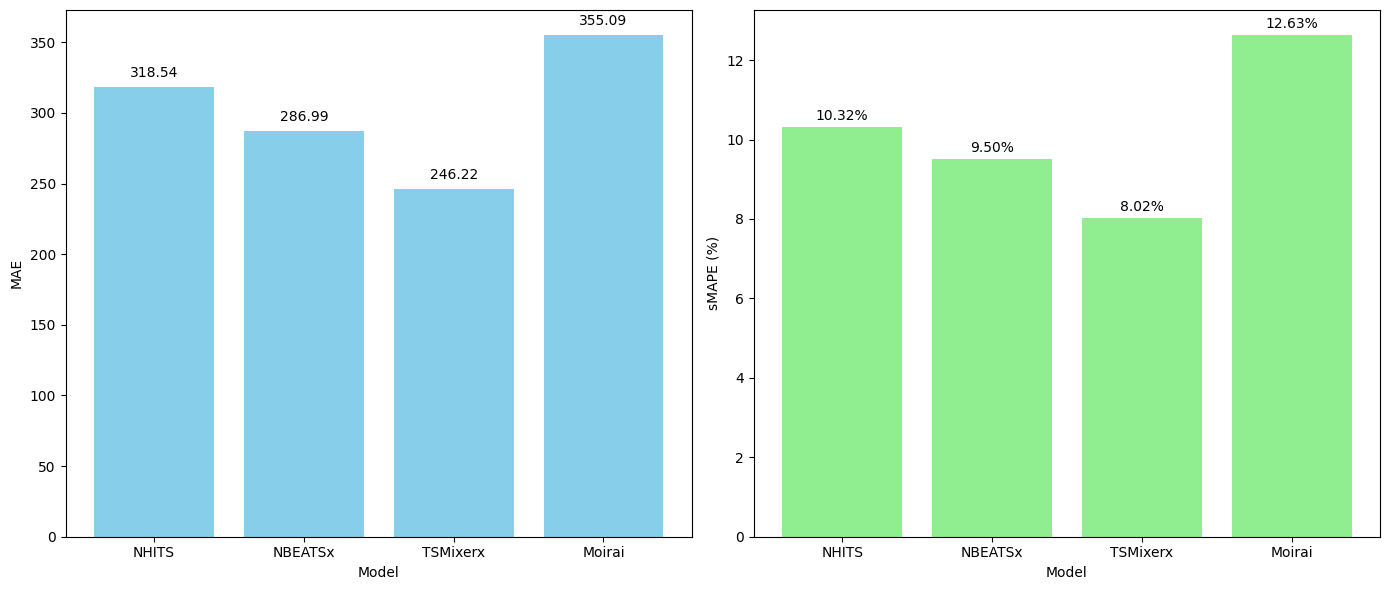

In [39]:
# Extract data for plotting
models = ['NHITS', 'NBEATSx', 'TSMixerx', 'Moirai']
mae_values = evaluation[evaluation['metric'] == 'mae'][models].values.flatten()
smape_values = evaluation[evaluation['metric'] == 'smape'][models].values.flatten() * 100  # Convert to percentage

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot for MAE
axes[0].bar(models, mae_values, color='skyblue')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('MAE')

# Add value labels on top of the bars for MAE
for i, v in enumerate(mae_values):
    axes[0].text(i, v + 5, f'{v:.2f}', ha='center', va='bottom')

# Bar plot for sMAPE
axes[1].bar(models, smape_values, color='lightgreen')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('sMAPE (%)')

# Add value labels on top of the bars for sMAPE (as percentages)
for i, v in enumerate(smape_values):
    axes[1].text(i, v + 0.1, f'{v:.2f}%', ha='center', va='bottom')

# Adjust layout and display the plot
plt.tight_layout()